### Loading of libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt

### Loading of dataframe

In [2]:
# gene presence-absence data
df = pd.read_csv("../../gene_presence_absence.csv", low_memory=False)

df

,Gene,Non-unique Gene name,Annotation,No. isolates,No. sequences,Avg sequences per isolate,Genome Fragment,Order within Fragment,Accessory Fragment,Accessory Order with Fragment,...,M1755613363,M1755747002,M1791056217,M1809960828,M1832718563,M1834217658,M1880016536,M1902817773,M1934342320,M1987574530
0,pyrK,NaN,"Dihydroorotate dehydrogenase B (NAD(+)), elect...",30,30,1.0,40,1192,NaN,NaN,...,JMJHKOJE_00960,JIAAJODB_01291,AKBMDOOL_00152,JNKBDPAB_00476,CEIIDJFG_01499,BGOMHBMC_01147,JDHLPIAI_00006,DEOHBMLB_00603,MLNBGCCH_01508,JCDIMBMJ_00270
1,ureG,NaN,Urease accessory protein UreG,30,30,1.0,40,3128,NaN,NaN,...,JMJHKOJE_00705,JIAAJODB_00910,AKBMDOOL_00735,JNKBDPAB_00140,CEIIDJFG_00398,BGOMHBMC_00148,JDHLPIAI_00411,DEOHBMLB_00517,MLNBGCCH_00936,JCDIMBMJ_00458
2,trxB,NaN,Thioredoxin reductase,30,30,1.0,40,3110,NaN,NaN,...,JMJHKOJE_00762,JIAAJODB_00786,AKBMDOOL_00823,JNKBDPAB_00263,CEIIDJFG_00382,BGOMHBMC_00132,JDHLPIAI_00396,DEOHBMLB_00683,MLNBGCCH_00276,JCDIMBMJ_00654
3,asrB,NaN,Anaerobic sulfite reductase subunit B,30,30,1.0,40,3152,NaN,NaN,...,JMJHKOJE_00486,JIAAJODB_00246,AKBMDOOL_00670,JNKBDPAB_00633,CEIIDJFG_00417,BGOMHBMC_00168,JDHLPIAI_00432,DEOHBMLB_00544,MLNBGCCH_00954,JCDIMBMJ_00924
4,btuD_1,NaN,Vitamin B12 import ATP-binding protein BtuD,30,30,1.0,40,3127,NaN,NaN,...,JMJHKOJE_00704,JIAAJODB_00909,AKBMDOOL_00734,JNKBDPAB_00141,CEIIDJFG_00397,BGOMHBMC_00147,JDHLPIAI_00410,DEOHBMLB_00516,MLNBGCCH_00935,JCDIMBMJ_00457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,group_98,NaN,hypothetical protein,1,1,1.0,40,2604,1.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEOHBMLB_00582,NaN,NaN
3363,purA_1,NaN,Adenylosuccinate synthetase,1,1,1.0,19,2,160.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3364,purA_2,NaN,Adenylosuccinate synthetase,1,1,1.0,19,1,160.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3365,group_991,NaN,hypothetical protein,1,1,1.0,40,2371,207.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DEOHBMLB_00371,NaN,NaN


### Calculate the Pangenome Size

In [3]:
pangenome_size = df.shape[0]
print(f"Pangenome size: {pangenome_size}")

Pangenome size: 3367


### Core genes count

In [4]:
# Get the number of columns representing genomes (ignore first few metadata columns)
num_genomes = len(df.columns) - 14  # The first 14 columns are metadata

# Calculate core genes (present in 95% or more of genomes)
core_threshold = int(num_genomes * 0.95)
df["num_present"] = df.iloc[:, 14:].count(axis=1)  # Count non-empty cells in genome columns

core_genes = df[df["num_present"] >= core_threshold].shape[0]
print(f"Number of core genes: {core_genes}")

Number of core genes: 158


### Accessory gene count

In [5]:
accessory_genes = pangenome_size - core_genes
print(f"Number of accessory genes: {accessory_genes}")

Number of accessory genes: 3209


### Presence-Absence Analysis for Strains

/home/ag8l/miniforge3/envs/ds-latests/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ag8l/miniforge3/envs/ds-latests/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1200x800 with 0 Axes>

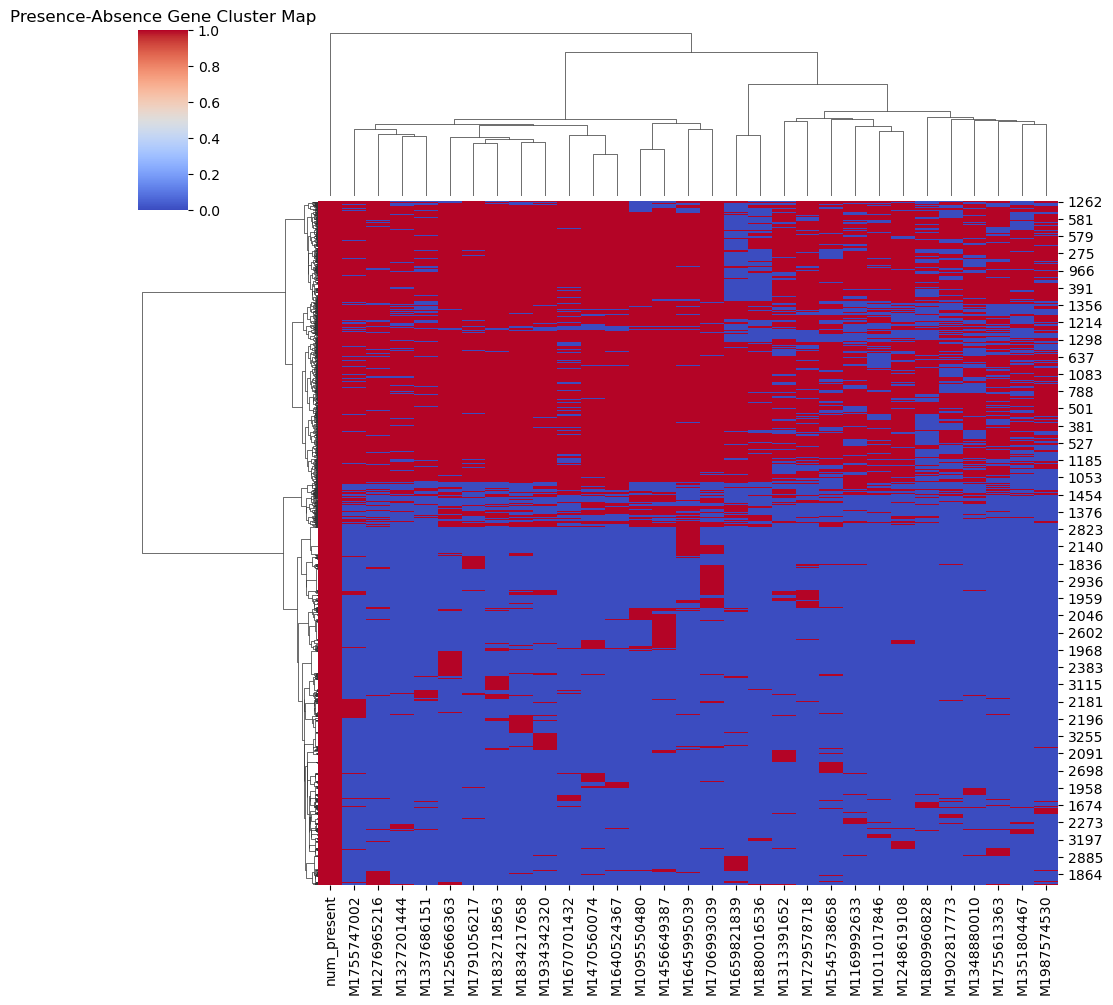

In [6]:
# Create a binary matrix (1 if gene is present, 0 if absent)
binary_matrix = df.iloc[:, 14:].notna().astype(int)

# Cluster the data and plot a heatmap
plt.figure(figsize=(12, 8))
sns.clustermap(binary_matrix, cmap="coolwarm", metric="euclidean", method="ward")
plt.title("Presence-Absence Gene Cluster Map")
plt.show()

### Open vs close pangenome

Heaps' Law Parameters: k=1112.62, alpha=0.33


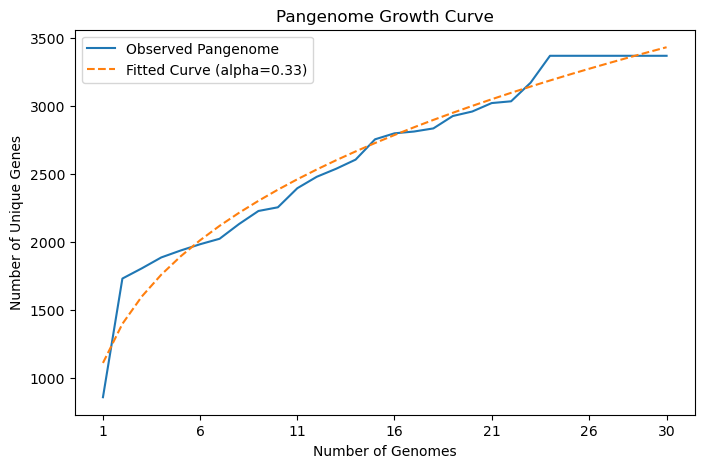

The pangenome is open (new genes continue to be discovered).


In [7]:
# Simulate genome addition order and track unique genes found
num_genomes_list = list(range(1, num_genomes + 1))
unique_genes = []

for i in num_genomes_list:
    sampled_genomes = df.iloc[:, 14:].sample(n=i, axis=1, random_state=42)
    unique_gene_count = (sampled_genomes.count(axis=1) > 0).sum()
    unique_genes.append(unique_gene_count)

# Fit Heaps' Law function (y = k * x^alpha)
def heaps_law(x, k, alpha):
    return k * (x ** alpha)

params, _ = opt.curve_fit(heaps_law, num_genomes_list, unique_genes)

k, alpha = params
print(f"Heaps' Law Parameters: k={k:.2f}, alpha={alpha:.2f}")

# Plot the pangenome curve
plt.figure(figsize=(8, 5))
plt.plot(num_genomes_list, unique_genes, label="Observed Pangenome")
plt.plot(num_genomes_list, heaps_law(np.array(num_genomes_list), k, alpha), '--', label=f"Fitted Curve (alpha={alpha:.2f})")
plt.xticks(ticks=np.arange(1, num_genomes + 1, step=5))  # Start at 1, adjust step for readability
plt.xticks(ticks=list(list(range(1, num_genomes, 5)) + [num_genomes]))  # Start at 1, adjust step for readability
plt.xlabel("Number of Genomes")
plt.ylabel("Number of Unique Genes")
plt.legend()
plt.title("Pangenome Growth Curve")
plt.show()

# Interpretation
if alpha < 1:
    print("The pangenome is open (new genes continue to be discovered).")
else:
    print("The pangenome is closed (gene discovery plateaus).")